In [1]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import librosa, librosa.display
from librosa.feature.spectral import mfcc
import math
import operator
import tensorflow as tf
from tensorflow.keras.models import save_model
import collections

In [17]:
# run for automatic data splitting

TEST_SIZE = 0.25
VALIDATION_SIZE = 0.2
DATA_PATH = "../music_data/data.json"

In [2]:
# run for manually split data

DATA_PATH = "../music_data/manual_data.json"

In [18]:
# load data for automatic split
with open(DATA_PATH, "r") as fp:
    data = json.load(fp)

    # convert lists to numpy arrays
    x = np.array(data["mfcc"])
    y = np.array(data["labels"])
    genres = data["mapping"]

In [3]:
# load manually split data
with open(DATA_PATH, "r") as fp:
    data = json.load(fp)

    # convert lists to numpy arrays
    x_train = np.array(data["mfcc"])
    y_train = np.array(data["labels"])
    x_test = np.array(data["mfccTest"])
    y_test = np.array(data["labelsTest"])
    genres = data["mapping"]

In [4]:
# shuffle manually split data
x_train, y_train = shuffle(x_train, y_train)

In [76]:
collections.Counter(y_train), collections.Counter(y_test)

(Counter({6: 800,
          4: 799,
          8: 800,
          3: 799,
          1: 800,
          0: 800,
          5: 800,
          7: 800,
          9: 800,
          2: 799}),
 Counter({0: 200,
          1: 199,
          2: 200,
          3: 200,
          4: 200,
          5: 200,
          6: 200,
          7: 200,
          8: 200,
          9: 200}))

In [5]:
x.shape

NameError: name 'x' is not defined

In [6]:
x_train.shape, y_train.shape

((7997, 130, 13), (7997,))

In [110]:
# create the train/test split (automatic)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=TEST_SIZE)

# CNN expects 3d array (for each sample) -> (130, 13, 1)
x_train = x_train[..., np.newaxis]  # 4d array -> (num_samples, 130, 30, 1)
x_test = x_test[..., np.newaxis]

In [7]:
# run if data is split manually

# CNN expects 3d array (for each sample) -> (130, 13, 1)
x_train = x_train[..., np.newaxis]  # 4d array -> (num_samples, 130, 30, 1)
x_test = x_test[..., np.newaxis]

In [8]:
x_train.shape, x_test.shape

((7997, 130, 13, 1), (1999, 130, 13, 1))

In [9]:
x_shape = x_train.shape                             # (num_samples, 130, 13, 1)
input_shape = (x_shape[1], x_shape[2], x_shape[3])

In [10]:
input_shape

(130, 13, 1)

In [11]:
# create model
model = keras.Sequential()

# 1st conv layer
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(keras.layers.AvgPool2D((2, 2)))
model.add(keras.layers.BatchNormalization())

# 2nd conv layer
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.AvgPool2D((2, 2)))
model.add(keras.layers.BatchNormalization())

# 3rd conv layer
model.add(keras.layers.Conv2D(64, (2, 2), activation='relu', padding='same'))
model.add(keras.layers.AvgPool2D((2, 2)))
model.add(keras.layers.BatchNormalization())

# flatten the output and feed it into dense layer
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(0.3))

# output layer
model.add(keras.layers.Dense(10, activation='softmax'))

In [12]:
# compile the network
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy'])

In [13]:
# save trained model
checkpoint_path = "../models/weights/manual_split_testing/cnn_genres.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [11]:
# take the checkpoint
# load_path = "../models/weights/trained_75%_cnn/cnn_genres.ckpt"
# model.load_weights(load_path)

In [17]:
# train the CNN
history = model.fit(x_train,
                    y_train,
                    validation_split=0.2,
                    batch_size=32,
                    shuffle=True,
                    epochs=10,
                    callbacks=[cp_callback])

Epoch 1/10
200/200 [==============================] - 2s 12ms/step - loss: 0.8001 - accuracy: 0.7314 - val_loss: 0.7577 - val_accuracy: 0.7581

Epoch 00001: saving model to ../models/weights/manual_split_testing\cnn_genres.ckpt
Epoch 2/10
200/200 [==============================] - 2s 11ms/step - loss: 0.7839 - accuracy: 0.7405 - val_loss: 0.7674 - val_accuracy: 0.7506

Epoch 00002: saving model to ../models/weights/manual_split_testing\cnn_genres.ckpt
Epoch 3/10
200/200 [==============================] - 2s 11ms/step - loss: 0.7615 - accuracy: 0.7394 - val_loss: 0.7666 - val_accuracy: 0.7519

Epoch 00003: saving model to ../models/weights/manual_split_testing\cnn_genres.ckpt
Epoch 4/10
200/200 [==============================] - 2s 11ms/step - loss: 0.7519 - accuracy: 0.7466 - val_loss: 0.7667 - val_accuracy: 0.7656

Epoch 00004: saving model to ../models/weights/manual_split_testing\cnn_genres.ckpt
Epoch 5/10
200/200 [==============================] - 2s 11ms/step - loss: 0.7387 - accu

In [18]:
# evaluate the CNN on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Accuracy on test set is", test_accuracy)

63/63 [==============================] - 1s 7ms/step - loss: 1.1054 - accuracy: 0.6723
Accuracy on test set is 0.6723361611366272


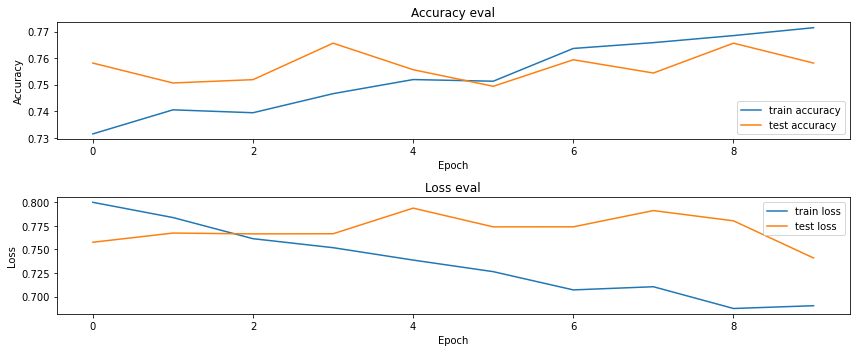

In [19]:
# plot accuracy and error over the epochs
_, axs = plt.subplots(2, figsize=(12, 5))

# create the accuracy subplot
axs[0].plot(history.history["accuracy"], label="train accuracy")
axs[0].plot(history.history["val_accuracy"], label="test accuracy")
axs[0].set_ylabel("Accuracy")
axs[0].set_xlabel("Epoch")
axs[0].legend(loc="lower right")
axs[0].set_title("Accuracy eval")

# create the error subplot
axs[1].plot(history.history["loss"], label="train loss")
axs[1].plot(history.history["val_loss"], label="test loss")
axs[1].set_ylabel("Loss")
axs[1].set_xlabel("Epoch")
axs[1].legend(loc="upper right")
axs[1].set_title("Loss eval")

plt.tight_layout()
plt.show()

In [20]:
# run predictions for creating confusion matrix
prediction = model.predict(x_test)
predicted_indexes = [np.argmax(index) for index in prediction]

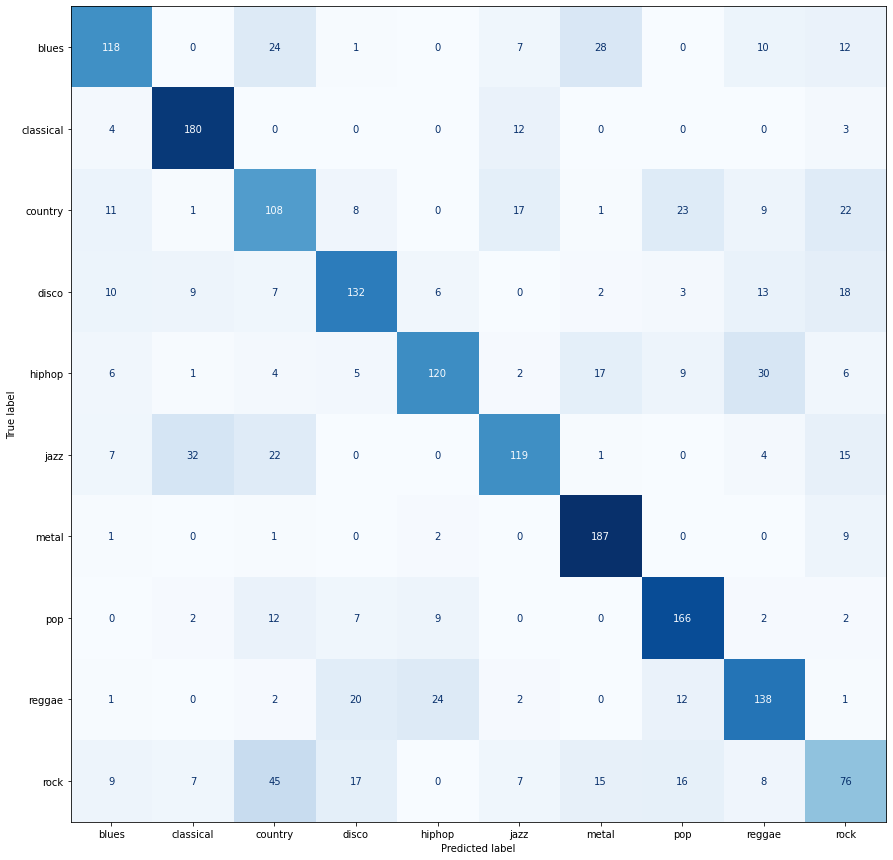

In [22]:
# display confusion matrix
M = confusion_matrix(y_test, predicted_indexes)
disp = ConfusionMatrixDisplay(confusion_matrix=M, display_labels=genres)

disp.plot(cmap=plt.cm.Blues, colorbar=False)
plt.rcParams["figure.figsize"] = (15, 15)
plt.show()

In [233]:
# save the whole model for reusable predicting
# filepath = '../models/manual_split_model'
# save_model(model, filepath)

In [235]:
# pick a song from premade data and predict it
SONG_NO = 256
print(x_test[SONG_NO].shape)
x_prediction = x_test[SONG_NO][np.newaxis, ...]
print(x_prediction.shape)

prediction = model.predict(x_prediction)
predicted_index = np.argmax(prediction)
print("Expected index: {}, Predicted index: {}".format(y_test[SONG_NO], predicted_index))
print("Predicted genre of the audio file is:", genres[predicted_index])

(130, 13, 1)
(1, 130, 13, 1)
Expected index: 1, Predicted index: 0
Predicted genre of the audio file is: blues


In [236]:
# load a custom song
file = "../music_files/nile.wav"
data, sr = librosa.load(file) # data = sr * time (ex. 22050 * 30sec of data in data array)

In [ ]:
# calculate the track duration in sec
track_duration = math.floor(data.shape[0]/sr)
print(track_duration, "seconds")

337 seconds


In [ ]:
# data for preprocessing the file (must be same as the trained files)
NUM_SEGMENT = track_duration//3     # cuts the track to segments of 3 seconds
N_MFCC=13
N_FFT=2048                          # no. of samples per STFT window (length of the windowed signal)
HOP_LENGTH=512                      # number of audio samples between adjancent STFT columns
NUM_SAMPLES_PER_SEGMENT = 66150

In [ ]:
data.shape

(7442433,)

In [ ]:
# processing file for prediction
prediction_mfcc = []
for s in range(NUM_SEGMENT):
    start_sample = NUM_SAMPLES_PER_SEGMENT * s
    end_sample = start_sample + NUM_SAMPLES_PER_SEGMENT

    mfcc = librosa.feature.mfcc(data[start_sample:end_sample], sr=sr, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)
    mfcc = mfcc.T

    # store MFCC for segment
    prediction_mfcc.append(mfcc.tolist())
prediction_mfcc = np.array(prediction_mfcc)

In [ ]:
print(prediction_mfcc.shape)

(112, 130, 13)


In [ ]:
prediction_mfcc[0][np.newaxis, ..., np.newaxis].shape

(1, 130, 13, 1)

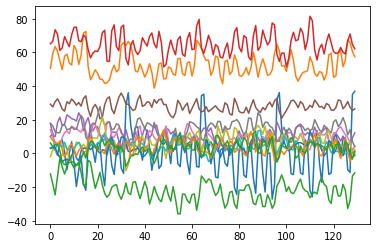

In [ ]:
prediction_mfcc[4].shape
plt.plot(prediction_mfcc[4])
plt.show()

In [ ]:
# dict for storing multiple genre values with count
predicted_values = {}
for i in range(prediction_mfcc.shape[0]):
    prediction = model.predict(prediction_mfcc[i][np.newaxis, ..., np.newaxis])
    predicted_index = np.argmax(prediction)
    predicted_values[genres[predicted_index]] = predicted_values.get(genres[predicted_index], 0) + 1

In [ ]:
# pulling the genre with max occurences in dict and printing the predicted value
predicted_genre = max(predicted_values.items(), key=operator.itemgetter(1))[0]
print(f"Your song is predicted to be of a {predicted_genre} genre.")

Your song is predicted to be of a metal genre.


In [ ]:
# give % of all genres the song is predicted to be
sum_all_values = sum(predicted_values.values())
print("Predicted genre percentages:")
for k, v in predicted_values.items():
    print(f"\t{k}: {round(v/sum_all_values*100, 2)}%")

Predicted genre percentages:
	rock: 10.71%
	disco: 1.79%
	metal: 50.89%
	pop: 19.64%
	hiphop: 16.07%
	country: 0.89%


In [ ]:
print(predicted_values)

{'rock': 12, 'disco': 2, 'metal': 57, 'pop': 22, 'hiphop': 18, 'country': 1}


In [ ]:
# # waveform
# plt.figure(figsize=(12, 5))
# librosa.display.waveplot(data, sr=sr)
# plt.xlabel("Time")
# plt.ylabel("Amplitude")
# plt.show()

In [ ]:
# # fft -> spectrum
# fft = np.fft.fft(data)
# magnitude = np.abs(fft)
# frequency = np.linspace(0 , sr, len(magnitude))

# left_frequency = frequency[:int(len(frequency)/2)]
# left_magnitude = magnitude[:int(len(frequency)/2)]

# plt.figure(figsize=(12, 5))
# plt.plot(left_frequency, left_magnitude)
# plt.xlabel("Frequency")
# plt.ylabel("Magnitude")
# plt.show()

In [ ]:
# # stft -> spectogram          
# stft = librosa.core.stft(data, hop_length=HOP_LENGTH, n_fft=N_FFT)
# spectogram = np.abs(stft)

# log_spectogram = librosa.amplitude_to_db(spectogram)

# plt.figure(figsize=(12, 5))
# librosa.display.specshow(log_spectogram, sr=sr, hop_length=HOP_LENGTH)
# plt.xlabel("Time")
# plt.ylabel("Frequency")
# plt.colorbar()
# plt.show()

In [ ]:
# # MFCC
# MFCCs = librosa.feature.mfcc(data, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mfcc=13)

# plt.figure(figsize=(12, 5))
# librosa.display.specshow(MFCCs, sr=sr, hop_length=HOP_LENGTH)
# plt.xlabel("Time")
# plt.ylabel("MFCC")
# plt.colorbar()
# plt.show()

In [ ]:
# # Fourier spectogram
# plt.figure(num=None, figsize=(20, 3))
# plt.subplot(111)
# plt.title('More common (Fourier) spectogram')
# plt.specgram(data, Fs=sr)
# plt.colorbar()
# plt.show()